# Species Age Abundance Distribution



In [23]:
]add BenchmarkTools

  Resolving package versions...
  Installed BenchmarkTools ─ v0.5.0
Updating `~/.julia/environments/v1.5/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0


In [6]:
using Phylo, Plots, DataFrames, Random, PyCall, Debugger, BenchmarkTools

In [744]:
?getnodedata

search: getnodedata getnoderecord



```
getnodedata(::AbstractTree, node)
```

retrieve the node data for a node of the tree.


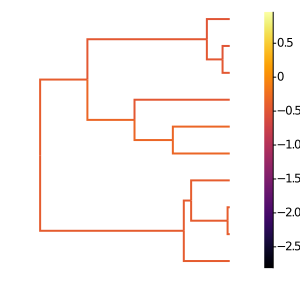

In [2]:
tree = rand(Ultrametric(10))
rand!(BrownianTrait(tree, "Trait"), tree)
plot(tree, size=(300, 300), line_z="Trait", lw=2)

In [5]:
names = getleafnames(tree)
nd = getnode(tree, names[1])
getnodedata(tree, nd)

Dict{String,Any} with 1 entry:
  "Trait" => -0.259053

# Prototyping different step() functions
These are 'traditional' MESS-style step functions where the local community is an array
of individuals with species ids.

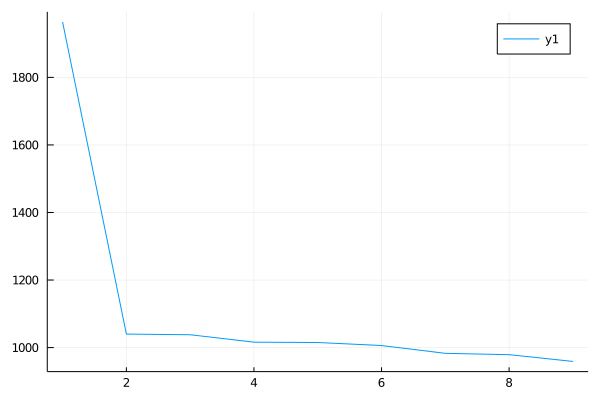

In [7]:
using DataStructures
using Distributions

J = 10000
m = 0.02

meta = floor.(Int, rand(LogNormal(5), 10))
loc = rand(meta, J)

    
function step!(loc, nsteps=500)
    for i = 1:nsteps
        samp = rand(loc)
        sidx = findall(x->x==samp, loc)[1]
        sname = popat!(loc, sidx)

        if rand() <= m
            push!(loc, rand(meta))
        else
            push!(loc, rand(loc))
        end
    end
end

function step2!(loc, nsteps=500)
    for i = 1:nsteps
        samp = rand(loc)
        vic_idx = findall(x->x==samp, loc)[1]
        if rand() <= m
            loc[vic_idx] = rand(meta)
        else
            new_samp = ""
            while true
                new_samp = rand(loc)
                new_idx = findall(x->x==new_samp, loc)[1]
                if vic_idx != new_idx
                    break
                end
            end
            loc[vic_idx] = new_samp
        end
    end
end

function step3!(loc, nsteps=500)
    l = length(loc)
    for i = 1:nsteps
        sidx = rand(1:l)
        samp = loc[sidx]
        if rand() <= m
            loc[sidx] = rand(meta)
        else
            idxs = collect(1:l)
            _ = popat!(idxs, sidx)
            loc[sidx] = loc[rand(idxs)]
        end
    end
end

function step4!(loc, nsteps=500)
    l = length(loc)
    for i = 1:nsteps
        sidx = rand(1:l)
        samp = loc[sidx]
        if rand() <= m
            loc[sidx] = rand(meta)
        else
            new_idx = 0
            while true
                new_idx = rand(loc)
                if new_idx != sidx
                    break
                end
            end
            loc[sidx] = loc[new_idx]
        end
    end
end


function plot_rank_abundance(loc)
    abunds = sort(collect(values(counter(loc))), rev=true)
    plot(1:length(abunds), abunds)
end

function plot_rank_abundance!(plt, loc)
    abunds = sort(collect(values(counter(loc))), rev=true)
    plot!(plt, 1:length(abunds), abunds)
end


step4!(loc, 100)
#plt = plot_rank_abundance!(plt, loc)
plt = plot_rank_abundance(loc)

## An alternate step() idea
This is based on the idea that the community is essentially walking the space of a simplex,
so the local community here is a vector of counts of individuals per metacommunity species.
I _think_ this would allow the local community to become arbitrarily large, because the
computational cost of the multinomial sample is constant with respect to local community size.

extinct 9
extinct 17
extinct 3


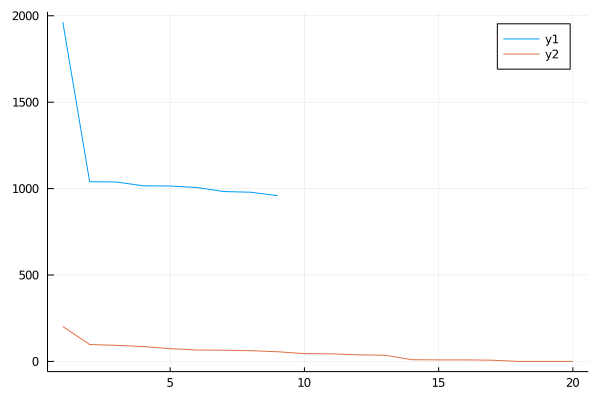

In [8]:
J = 1000
m = 0
meta = floor.(Int, rand(LogNormal(5), 20))
loc_simplex = rand(Multinomial(J, meta/sum(meta)))

function multinomial_samp(com)
    p = com/sum(com)
    a = rand(Multinomial(1, p))
    findall(x->x==1, a)[1]
end

function plot_rac_simplex(loc)
    abunds = sort(loc, rev=true)
    plot(1:length(abunds), abunds)
end
function plot_rac_simplex!(plt, loc)
    abunds = sort(loc, rev=true)
    plot!(plt, 1:length(abunds), abunds)
end

function step0!(loc_simplex, nsteps=500)
    for i = 1:nsteps
        sidx = multinomial_samp(loc_simplex)
        samp = loc_simplex[sidx]
        loc_simplex[sidx] -= 1
        if loc_simplex[sidx] == 0 print("extinct ", sidx, "\n") end
        if rand() <= m
            loc_simplex[sidx] += 0
        else
            loc_simplex[multinomial_samp(loc_simplex)] += 1
        end
    end
end
step0!(loc_simplex, 10000)
if false
    plt = plot_rac_simplex(loc_simplex)
else
    plt = plot_rac_simplex!(plt, loc_simplex)
end

In [9]:
#Multnomial(loc)
p = meta/sum(meta)
#print(meta)
@time multinomial_samp(meta)
#@time rand()
@time step0!(loc_simplex)
@time step!(loc)
@time step2!(loc)
@time step3!(loc)
@time step4!(loc)


  0.000015 seconds (8 allocations: 912 bytes)
  0.002928 seconds (6.01 k allocations: 712.949 KiB)
  0.094065 seconds (117.50 k allocations: 17.539 MiB)
  0.312920 seconds (1.35 M allocations: 51.645 MiB)
  0.106758 seconds (60.25 k allocations: 41.253 MiB, 50.86% gc time)
  0.002011 seconds (1.01 k allocations: 41.076 KiB)


## Formulate the metacommunity as a dataframe

In [10]:
function make_metacommunity(S_m=10)
    df = DataFrame()
    df[:meta_abund] = floor.(Int64, rand(LogNormal(7), S_m))
    df[:coltime] = zeros(Int64, S_m)
    df[:trait] = rand(Normal(0, 2), S_m)
    df[:local_abund] = zeros(Int64, S_m)
    df[:migrants] = zeros(Int64, S_m)
    df
end

function init_local!(meta, J=1000, init="landbridge")
    if init == "landbridge"
        p = meta[:meta_abund]/sum(meta[:meta_abund])
        meta[:local_abund] = rand(Multinomial(J, p))
    elseif init == "volcanic"
        mx = findall(a->a==maximum(meta[:meta_abund]), meta[:meta_abund])[1]
        meta[:local_abund][mx] = J
    else
        throw("Bad init_local value", init)
    end
end

function neutral_samp(com)
    p = com/sum(com)
    sidx = rand(Multinomial(1, p))
    findall(x->x==1, sidx)[1]
end

function filter_samp(abunds, traits, optimum, e_s)
    death_probs = 1 .- exp.(-((traits.-optimum).^2)./e_s)
    tot_probs = abunds .* death_probs
    p = tot_probs / sum(tot_probs)
    sidx = rand(Multinomial(1, p))
    findall(x->x==1, sidx)[1]
end

function competition_samp(abunds, traits, e_s)
    # abundance weighted mean trait value
    mean_trait = sum(traits .* abunds)/sum(abunds)
    death_probs = exp.(-((traits.-mean_trait).^2)./e_s)
    tot_probs = abunds .* death_probs
    # If probs are too small then tot_probs will be all zeros so rescue it
    if sum(tot_probs) == 0
        # Create a vector of 1s masked to species that are > 0 abundance
        tot_probs = abunds .> 0
    end
    p = abs.(tot_probs / sum(tot_probs))
    sidx = rand(Multinomial(1, p))
    findall(x->x==1, sidx)[1]
end

function taxon_cycle_samp(abunds, ages, t, e_s, ndd)
    # death probability is a function of 
    death_probs = exp.(-((ages./t).^2)./e_s)
    death_probs = death_probs ./ (1 .- (ndd .* abunds./sum(abunds)))
    tot_probs = death_probs .* abunds
    if sum(tot_probs) == 0 tot_probs = abunds .> 0 end
    # In the case of only one species you get a divide by zero
    # during calculating the death probs, which gives Inf here
    if sum(tot_probs) == Inf tot_probs = abunds .> 0 end
    p = tot_probs / sum(tot_probs)
    sidx = rand(Multinomial(1, p))
    findall(x->x==1, sidx)[1]
end

function steps!(meta, assembly_model, ngens, m, e_s, ndd, optimum=1)
    for gen = 1:ngens
        # Each generation is J/2 steps
        for i = 1:sum(meta[:local_abund])/2
            if assembly_model == "neutral"
                sidx = neutral_samp(meta[:local_abund])
            elseif assembly_model == "filtering"
                sidx = filter_samp(meta[:local_abund], meta[:trait], optimum, e_s)
            elseif assembly_model == "taxon_cycle"
                sidx = taxon_cycle_samp(meta[:local_abund], meta[:coltime], gen, e_s, ndd)
            else
                sidx = competition_samp(meta[:local_abund], meta[:trait], e_s)
            end
            meta[:local_abund][sidx] -= 1
            if meta[:local_abund][sidx] == 0
                meta[:coltime][sidx] = 0
                meta[:migrants][sidx] = 0
            end
            if rand() <= m
                cidx = neutral_samp(meta[:meta_abund])
                meta[:local_abund][cidx] += 1
                # If this is a recolonization update the migrants count,
                # otherwise update coltime (new colonization)
                meta[:local_abund][cidx] > 1 ? meta[:migrants][cidx] += 1 : meta[:coltime][cidx] = gen
            else
                meta[:local_abund][neutral_samp(meta[:local_abund])] += 1
            end
        end
    end
end

assembly_model = "taxon_cycle"
m = 0.01
meta = make_metacommunity(10)
init_local!(meta, 1000, "volcanic")
steps!(meta, assembly_model, 10, 0.01, 1000000000, 0)
print(meta)

10×5 DataFrame
│ Row │ meta_abund │ coltime │ trait     │ local_abund │ migrants │
│     │ Int64      │ Int64   │ Float64   │ Int64       │ Int64    │
├─────┼────────────┼─────────┼───────────┼─────────────┼──────────┤
│ 1   │ 393        │ 3       │ 1.99167   │ 4           │ 4        │
│ 2   │ 238        │ 0       │ 0.296467  │ 0           │ 0        │
│ 3   │ 432        │ 10      │ -2.4916   │ 2           │ 0        │
│ 4   │ 549        │ 9       │ -2.52808  │ 1           │ 0        │
│ 5   │ 561        │ 0       │ -0.463616 │ 0           │ 0        │
│ 6   │ 529        │ 0       │ -3.40039  │ 0           │ 0        │
│ 7   │ 1014       │ 0       │ -2.20732  │ 0           │ 0        │
│ 8   │ 5412       │ 0       │ -1.27429  │ 986         │ 17       │
│ 9   │ 488        │ 8       │ 0.576864  │ 2           │ 1        │
│ 10  │ 1586       │ 2       │ -0.601004 │ 5           │ 5        │

In [11]:
function run(nsims, m::Any=0.01, e_s::Any=1, ndd::Any=0)
    res = Any[]
    for sim = 1:nsims
        assembly_model = "taxon_cycle"
        meta = make_metacommunity(10)
        init_local!(meta, 10000, "volcanic")
        steps!(meta, assembly_model, 1000, m, e_s, ndd)
        push!(res, meta)
    end
    res
end
results = run(1, 0.001, 0.000000001, 0.05)


1-element Array{Any,1}:
 10×5 DataFrame
│ Row │ meta_abund │ coltime │ trait     │ local_abund │ migrants │
│     │ Int64      │ Int64   │ Float64   │ Int64       │ Int64    │
├─────┼────────────┼─────────┼───────────┼─────────────┼──────────┤
│ 1   │ 4287       │ 0       │ -0.842524 │ 0           │ 0        │
│ 2   │ 6444       │ 0       │ -1.41822  │ 0           │ 0        │
│ 3   │ 659        │ 0       │ -0.706187 │ 0           │ 0        │
│ 4   │ 1377       │ 0       │ -1.77492  │ 0           │ 0        │
│ 5   │ 3580       │ 0       │ -2.6232   │ 0           │ 0        │
│ 6   │ 1396       │ 0       │ 0.209815  │ 0           │ 0        │
│ 7   │ 746        │ 0       │ 0.265451  │ 0           │ 0        │
│ 8   │ 2750       │ 0       │ -2.60889  │ 0           │ 0        │
│ 9   │ 1510       │ 0       │ 2.26127   │ 0           │ 0        │
│ 10  │ 1531       │ 3       │ 1.1353    │ 10000       │ 294      │

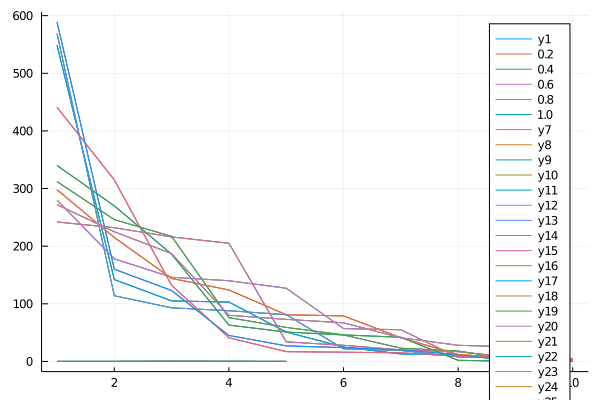

In [1659]:
## Pure neutral
plt = plot_rac_simplex(results[1][:local_abund])
for i in results
    plot_rac_simplex!(plt, i[:local_abund])
end
plt

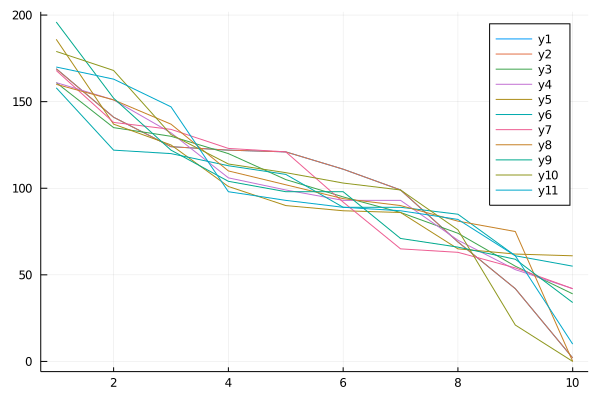

In [1667]:
## Neutral with density dependence
plt =  plot_rac_simplex(results[1][:local_abund])
for i in results
    plot_rac_simplex!(plt, i[:local_abund])
end
plt

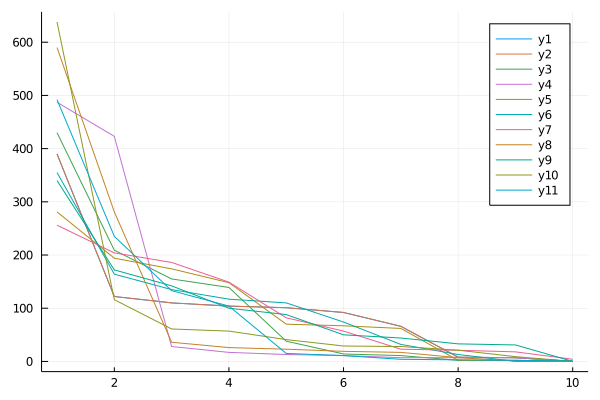

In [1672]:
## taxon cycle without density dependence
plt =  plot_rac_simplex(results[1][:local_abund])
for i in results
    plot_rac_simplex!(plt, i[:local_abund])
end
plt

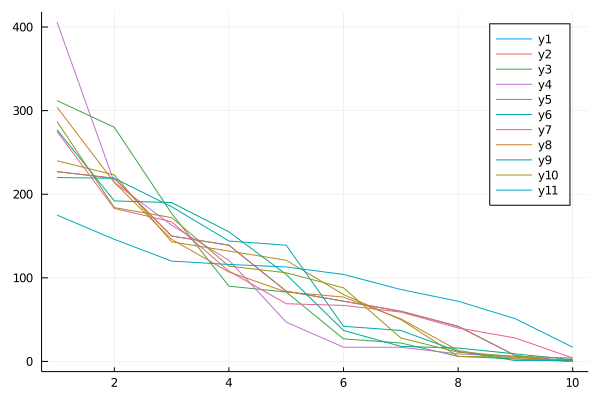

In [1670]:
## taxon cycle with density dependence
plt =  plot_rac_simplex(results[1][:local_abund])
for i in results
    plot_rac_simplex!(plt, i[:local_abund])
end
plt

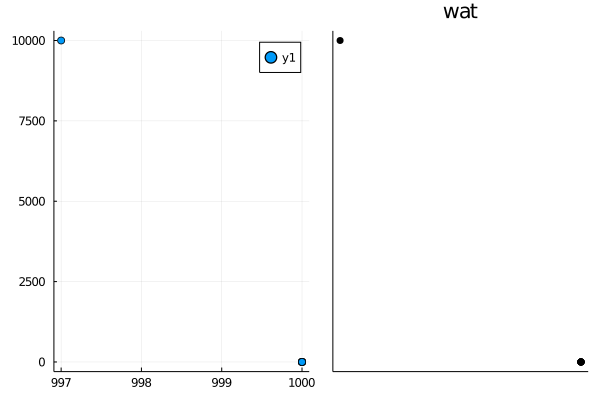

In [12]:

function plot_saad(meta, title="")
    ages = 1000 .- meta[:coltime]
    abunds = meta[:local_abund]
    scatter(ages, abunds, title=title, legend=false, markercolor=:black, grid=false, ticks=false)
end
function plot_saad!(plt, meta, title="")
    ages = 1000 .- meta[:coltime]
    abunds = meta[:local_abund]
    scatter!(plt, ages, abunds, title=title, legend=false, markercolor=:black, grid=false, ticks=false)
end

title = "wat"
title1 = "do"
plt =  plot_saad(results[1], title)
for i in results[2:end]
    plot_saad!(plt, i, title1)
end
plt1 = scatter(1000 .- results[1][:coltime], results[1][:local_abund])
plot(plt1, plt, layout=2)


In [13]:
m = 0.001
plots = Any[]
for e_s = [1000000, 10, 1]
    for ndd = [0, 0.1, 0.5]
        print("$e_s $ndd\t")
        res = run(5, m, e_s, ndd)
        plt =  plot_saad(res[1])
        for i in res[2:end]
            plot_saad!(plt, i)
        end
        push!(plots, plt)
    end
end

1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	

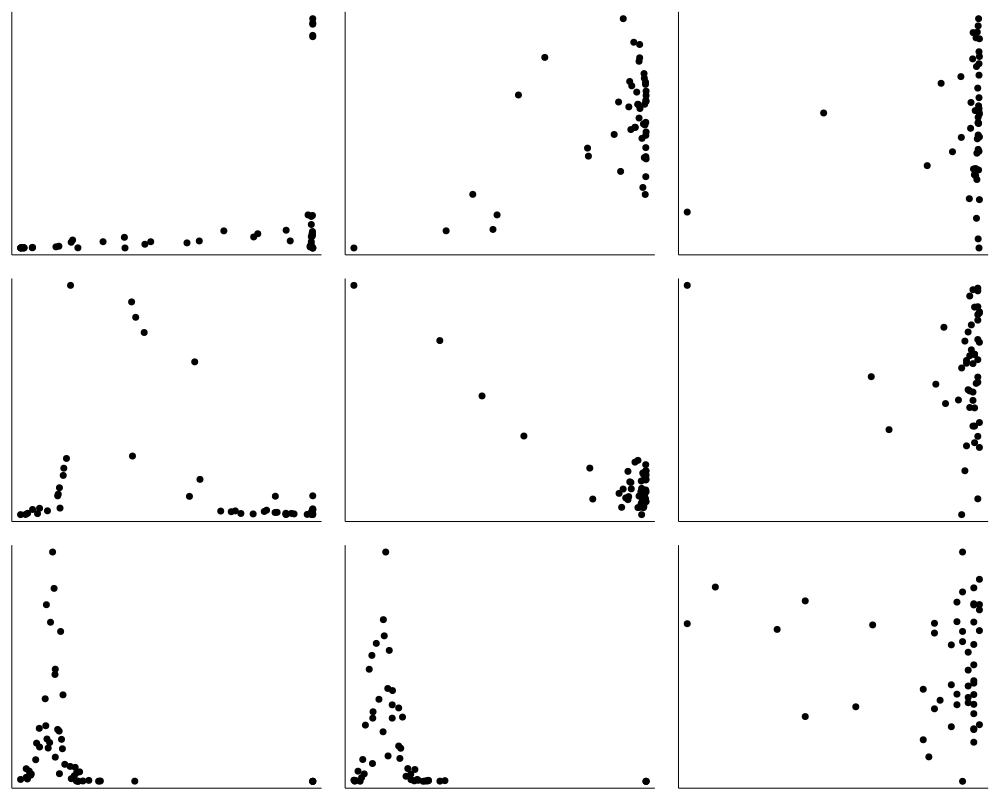

In [14]:
plot(plots..., layout=9, size=(1000, 800))
#png("sim_SAAD")

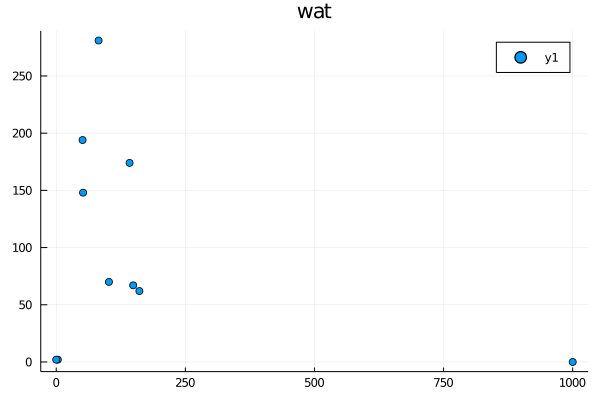

In [1791]:
plt =  plot_saad(results[4], title)

In [1788]:
function taxon_cycle_samp(abunds, ages, t, e_s, ndd)
    death_probs = exp.(-((ages./t).^2).*e_s)
    death_probs = death_probs ./ (1 .- (ndd .* abunds./sum(abunds)))
    tot_probs = death_probs .* abunds
    if sum(tot_probs) == 0 tot_probs = abunds .> 0 end
    if sum(tot_probs) == Inf tot_probs = abunds .> 0 end
    p = tot_probs / sum(tot_probs)
    sidx = rand(Multinomial(1, p))
    findall(x->x==1, sidx)[1]
    p
end

abund = meta[:local_abund]
times = meta[:coltime]
print("$abund\n$times")
for i in [1, 0.5, 0, -0.1, -0.5]
    r = taxon_cycle_samp(abund, times, 1, i, 1)
    print("\n$r")
end

[5, 0, 9, 5, 6, 0, 0, 0, 0, 975]
[3, 0, 7, 5, 2, 0, 0, 0, 0, 0]
[1.5901230805730067e-8, 0.0, 1.220881173059471e-25, 1.7894477869740983e-15, 2.8347913134931033e-6, 0.0, 0.0, 0.0, 0.0, 0.9999971493074539]
[1.4313552303428154e-6, 0.0, 5.331872094116336e-15, 4.80166187032806e-10, 2.0946023018542834e-5, 0.0, 0.0, 0.0, 0.0, 0.9999776221415796]
[0.0001287662772354784, 0.0, 0.00023271483605322082, 0.0001287662772354784, 0.00015467498492873361, 0.0, 0.0, 0.0, 0.0, 0.999355077624547]
[0.0003066786566447423, 0.0, 0.03026100945272241, 0.0015189893302313448, 0.0002234365688871394, 0.0, 0.0, 0.0, 0.0, 0.9676898859915143]
[1.1404779967383069e-9, 0.0, 0.9999965007015735, 3.3997169934224064e-6, 1.1245237921797166e-10, 0.0, 0.0, 0.0, 0.0, 9.832850263952682e-8]

In [1680]:
abund = zeros(5)
times = zeros(5)
abund[1] = 1000
taxon_cycle_samp(abund, times, 1, 1, 1)

LoadError: ArgumentError: p = [NaN, 0.0, 0.0, 0.0, 0.0] is not a probability vector.

In [ ]:
t = 2000
p = taxon_cycle_samp(meta[:local_abund], meta[:coltime], t, 10000000000, 0)
plt = plot(p[1:8])
for i in 1:5
    p = taxon_cycle_samp(meta[:local_abund], meta[:coltime], t, i/5, 0)
    plot!(plt, p[1:8])
end
plt

## Evaluate behavior of the taxon_cycle function

[4221, 194, 2349, 1764, 1458]
[0.04279667622476361, 0.31489387408063707, 0.17021610265345594, 0.22299785589122728, 0.2490954911499161]
[0.09613435784679973, 0.2607688520125967, 0.19172287388446468, 0.21944412220203993, 0.2319297940540988]
[0.12404090443111118, 0.24125869878005118, 0.19652982071883082, 0.2150445660829938, 0.22312600998701296]
[0.1403847374257477, 0.23121097055397277, 0.19825198499162136, 0.21210092160707705, 0.21805138542158128]
[0.1510109547727505, 0.22509159966245185, 0.199033680363741, 0.2100809064664153, 0.21478285873464137]

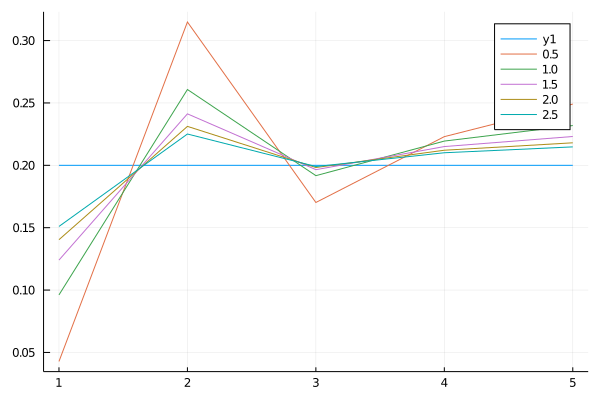

In [1598]:
# same abundance different coltimes. As e_s goes from small to large
# older species become less and less selectively disadvantaged
abund = repeat([100], 5)
times = floor.(Int64, rand(LogNormal(7), 5))
t = maximum(times)
print(times)
p = taxon_cycle_samp(abund, times, t, 10000000000, 0)
plt = plot(p)
for i in 1:5
    p = taxon_cycle_samp(abund, times, t, i/2, 0)
    plot!(plt, p, label=i/2)
    print("\n", p)
end
plt

[100, 100, 100, 100, 100][264, 1530, 3922, 740, 3503]

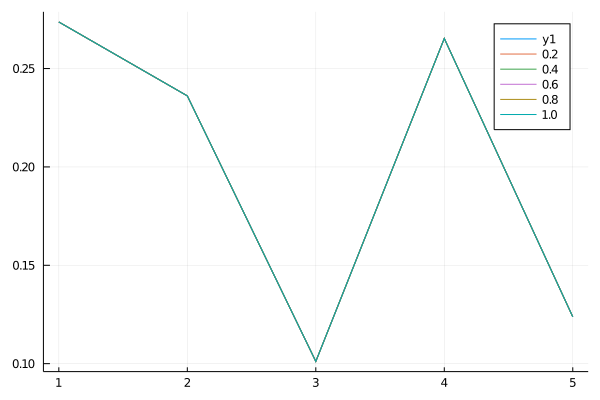

In [1574]:
# same abundance different coltimes. ndd has no effect.
abund = repeat([100], 5)
times = floor.(Int64, rand(LogNormal(7), 5))
t = maximum(times)
print(abund, times)
p = taxon_cycle_samp(abund, times, t, 1, 0)
plt = plot(p)
for i in 1:5
    p = taxon_cycle_samp(abund, times, t, 1, i/5)
    plot!(plt, p, label=i/5)
end
plt

[1867, 1740, 4103, 2667, 1092]

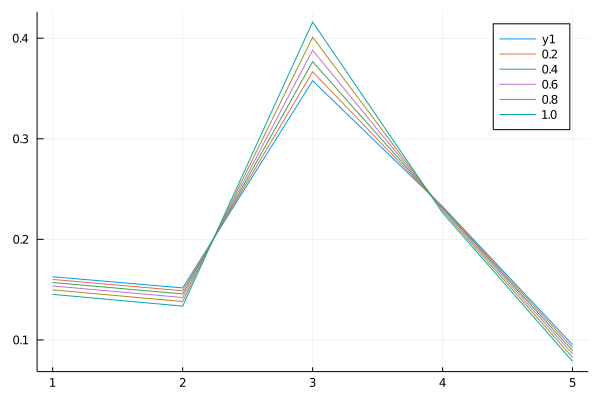

In [1601]:
# same coltimes different abunds. As ndd increases the
# probability of rare species being selected decreases
abund = floor.(Int64, rand(LogNormal(7), 5))
times = repeat([100], 5)
t = maximum(times)
print(abund)
p = taxon_cycle_samp(abund, times, t, 100000, 0)
plt = plot(p)
for i in 1:5
    p = taxon_cycle_samp(abund, times, t, 10000, i/5)
    plot!(plt, p, label=i/5)
end
plt

[100, 100, 100, 100, 100]

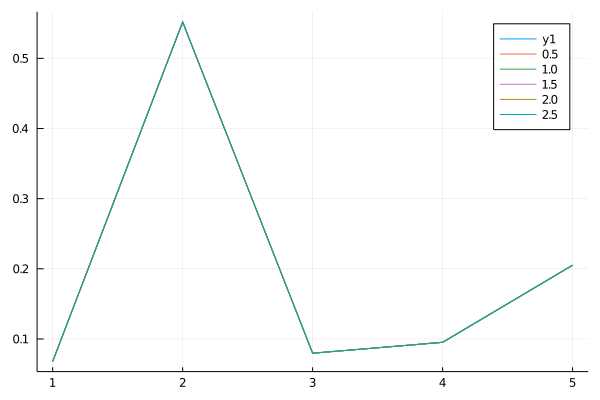

In [1599]:
# same coltimes different abunds. e_s has no effect on relative fitness
abund = floor.(Int64, rand(LogNormal(7), 5))
times = repeat([100], 5)
t = maximum(times) + 100
print(times)
p = taxon_cycle_samp(abund, times, t, 10000000000, 0)
plt = plot(p)
for i in 1:5
    p = taxon_cycle_samp(abund, times, t, i/2, 0)
    plot!(plt, p, label=i/2)
end
plt

In [1536]:
 maximum(floor.(Int64, rand(LogNormal(7), 5)))

2485

In [1174]:
msprime = pyimport("msprime")

tree_sequence = msprime.simulate(Ne=10000,
                                length = 300,
                                mutation_rate = 1e-7,
                                sample_size=10)
tree_sequence.diversity()

0-dimensional Array{Float64,0}:
0.005259259259259259

In [1314]:
mx = findall(a->a==maximum(meta[:meta_abund]), meta[:meta_abund])
print(mx)
meta[:meta_abund][mx]

[52]

1-element Array{Int64,1}:
 15040

In [1347]:
#filtered
print(2 * 28161392 + 2 * 41867450 + 2 * 62073131 + 2 * 23239940 + 2 * 27328619)

34148653 + 34148653 + 50575912 + 50575912 + 75938614 + 75938614 + 28404794 + 28404794 + 33023621 + 33023621 + 16929313 + 16929313

365341064

478041814

In [46]:
for i in 1:200
    results = Any[]
    m = 0.001
    plots = Any[]
    for e_s = [1000000, 10, 1]
        for ndd = [0, 0.1, 0.5]
            print("$e_s $ndd\t")
            res = run(1, m, e_s, ndd)
            push!(results, res)
            ag = join(getindex(res)[:, :coltime], " ")
            ab = join(getindex(res)[:, :local_abund], " ")
            open("SIMOUT.txt","a") do io
               println(io, join([e_s, ndd, ag, ab], "\t"))
            end
            plt =  plot_saad(res[1])
            for i in res[2:end]
                plot_saad!(plt, i)
            end
            push!(plots, plt)
        end
    end
end

1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1

10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.0	1 0.1	1 0.5	1000000 0.0	1000000 0.1	1000000 0.5	10 0.0	10 0.1	10 0.5	1 0.